# Classification on galaxy zoo dataset 

https://www.kaggle.com/c/galaxy-zoo-the-galaxy-challenge/overview

### Data includes images with unique IDs (jpg files) and a table containing the probabilities of each class in the columns




### Read table with classes

In [1]:
import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mplimg 
import numpy as np
import os 
import tarfile
import urllib 
import pandas as pd
import seaborn as sns
from glob import glob
from tqdm import tqdm
 
# Use pandas to retrieve data file
#url = '' # use to fetch data file each time

# Read in CSV file with probabilities
df = pd.read_csv("training_solutions_rev1.csv",index_col=0)
#classprobs.values.astype(np.float32)
df.info()

FileNotFoundError: [Errno 2] File train.csv does not exist: 'train.csv'

## Read images

### Using PIL: define read function to crop/resize image but doens't load pixel data to conserve memory
___```np.vectorize``` makes read function work with iterables like a list of filenames___


In [61]:
# Image reading function that conserves memory
from PIL import Image


def read_image(file,crop_size=(200,200),out_size=(64,64)):
    with Image.open(file) as im:
        im.crop(((im.size[1]-crop_size[1])//2, (im.size[0]-crop_size[0])//2, \
                (im.size[1]+crop_size[1])//2, (im.size[0]+crop_size[0])//2 )).resize(out_size).convert('L')
       # imdat=im.load()
    
        return np.asarray(im,dtype=np.float32)
        
    
# def load_image(file):
#     im=read_image()
#     return Image.Image.load(PILImage,'F').asarray()
    
read_image_list = np.vectorize(read_image,excluded=['crop_size','out_size'],otypes=np.array([Image.Image]))

#load_image_list = np.vectorize(load_image,otypes=[np.ndarray])
#load_image_data = np.vectorize(Image.load,excluded=['crop_size','out_size'],otypes=np.array([np.ndarray]))

Use ```glob``` + ```np.sort``` to define a sorted array of image filenames

__Define crop and resize parameters as keyword args__


In [62]:
path='images_training_rev1/*'
flist = np.sort(np.array(glob(path)))
#print(flist)

__Test ```read_image_list``` on subset of images for plotting and data exploration__

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


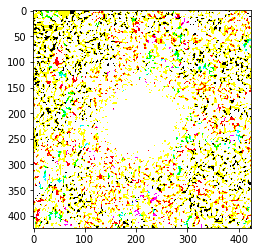

In [64]:
crop_size=(200,200)
out_size=(64,64)
kwargs={'crop_size':crop_size,'out_size':out_size}
ims=read_image_list(flist[:100])
ims[0]
#print(np.asarray(ims[0]))
plt.imshow(ims[0])
#im_sub = load_image_list(imlist_sub)
#im_sub

TypeError: Image data of dtype object cannot be converted to float

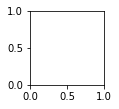

In [60]:
import skimage.io
from skimage.io import imshow_collection

#help(imshow_collection)
#fig,axs=plt.subplots(10,10)
fig=plt.figure(figsize=(16,16))
gs=fig.add_gridspec(nrows=10,ncols=10)
k=0
for i in range(10):
    for j in range(10):
        ax_ij = fig.add_subplot(gs[i,j])
        ax_ij.imshow(ims)
        ax_ij.set_xticklabels([])
        ax_ij.set_yticklabels([])
        k+=1
fig.tight_layout()
#skimage.io.show()
plt.show()

## Now do batch learning: create binary classifier for Q1.1: Is is smooth/round or is it not?

In [191]:
df_c1 = df.loc[:,"Class1.1":"Class1.3"].copy()

Y_train = (df_c1.values.argmax(axis=1) == 0) # now target is simply ROUND/SMOOTH OR NOT

Y_train

array([False, False,  True, ..., False, False,  True])

In [192]:
batch_size = 5000

N_samp = df.shape[0]

print("Implementing %i batches with %i samples each"%(N_batches,batch_size))

Implementing 13 batches with 5000 samples each


In [206]:
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split

# define image processing parameters
s_crop=(200,200)
s_image=(64,64)
kwargs={'crop_size':s_crop,'out_size':s_image}


# initialize the classifier
sgd_clf = SGDClassifier(random_state=1, loss='modified_huber', penalty='l2', tol=1.0e-3, \
                        verbose=1, shuffle=False, warm_start=False, early_stopping=False)

n_batch=[]
accuracy=[]
n=0
while n*batch_size < N_samp: # save last two batches for testing
    # define X of batch (reshape images if necessary)
    #print("INDEX %i : %i"%(n * batch_size, (n+1)*batch_size))
    
#     if (n==N_batches-1): # if the last batch
#         X_train_batch = read_image_list( flist[n * batch_size : ] )#.concatenate().\
#         reshape((np.size(imcl.files[n *batch_size:]),-1))
#         Y_train_batch = Y_train_bin1[n * batch_size : ]
 #   else:
    X_batch = read_image_list(flist[n * batch_size : (n+1)*batch_size],**kwargs) #.concatenate().reshape((batch_size,-1))
    Y_batch = Y_train[n * batch_size : (n+1)*batch_size]
    
    X_train_batch,X_test_batch,Y_train_batch,Y_test_batch=train_test_split(X_batch,Y_batch,random_state=1,shuffle=True,)
    
    print(X_train_batch,Y_train_batch)
    
    n+=1
    break
    # FIT     
 #   sgd_clf.partial_fit(X_train_batch, Y_train_batch, classes=[True,False])
    
#     # ACCURACY
#     batch_score = sgd_clf.score(X_train_batch, Y_train_batch)
    
#     print("Accuracy score (train): %.1f PRECENT"%(batch_score*100))
#     n_batch.append(n)
#     accuracy_score.append(batch_score)

AttributeError: 'numpy.ndarray' object has no attribute 'getdata'

### Using skimage: ImageCollection

In [29]:
# # display image
# from skimage import data,filters,io
# from skimage import img_as_float32, img_as_uint, img_as_ubyte
# from sklearn.base import BaseEstimator, TransformerMixin
# from skimage.feature import hog
# from skimage.io import imread,imshow_collection,ImageCollection
# from skimage.transform import rescale,resize
# # from skimage.io import ImageCollection, concatenate_images
# # from skimage.util import img_as_ubyte,img_as_uint,img_as_float

# # img_shape = (424,424)
# # crop_shape = (256,256)
# # train_img_shape = (32,32)

# #flist = np.sort(np.array(glob('images_training_rev1/*')))
# flist = ['images_training_rev1/%i.jpg'%i for i in Y_train_class1.index[:]]

# #~~~ DEFINE FUNCTION TO READ IN IMAGES AND CROP, FLATTEN

# # crop image (np array) from original size to output sieze
# def crop(image,size_orig,size_crop):
#     return image[(size_orig-size_crop)//2:(size_orig+size_crop)//2,\
#                 (size_orig-size_crop)//2:(size_orig+size_crop)//2]

# # read image file and crop
# def read_crop(f,size_orig,size_crop,size_image):
#     i=crop(plt.imread(f), size_orig,size_crop)
#     i=resize(i,(size_image,size_image))
#     return i.astype(np.float32)

In [30]:
img_dim = 424
crop_dim= 192
resize_dim = 64

#~~ DEFINE IMAGE COLLECTION

load_func_kwargs={'size_orig':img_dim,'size_crop':crop_dim, 'size_image':resize_dim}
#print(flist)
imcl = ImageCollection(flist, load_func=read_crop, conserve_memory=True, **load_func_kwargs)

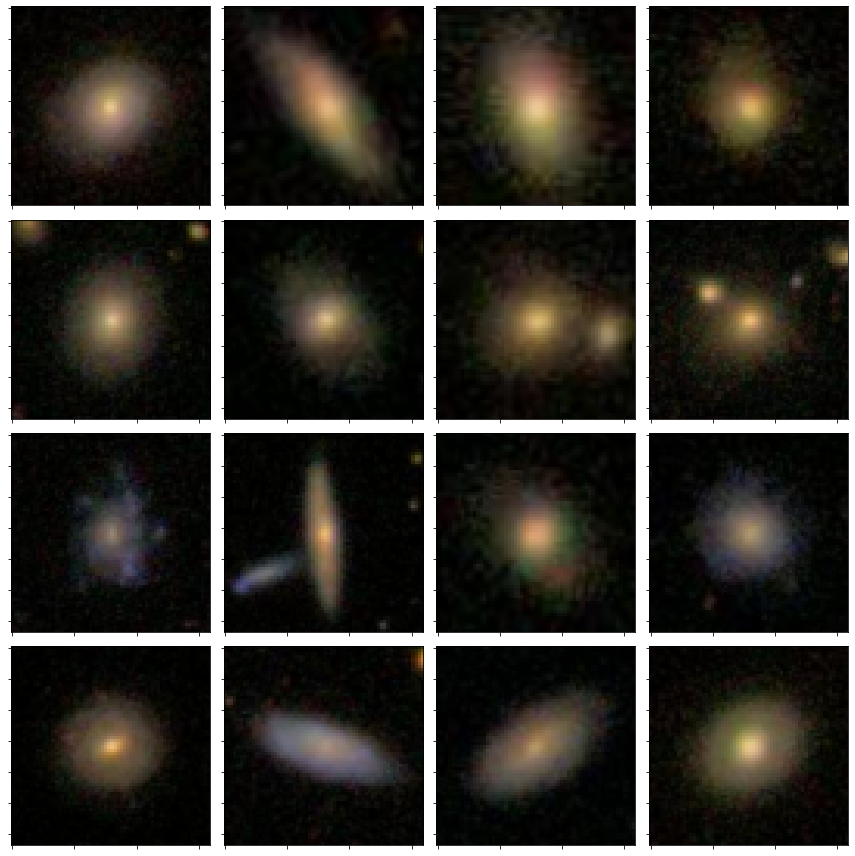

In [31]:

imcl_plot = ImageCollection(flist[:16], load_func=read_crop, conserve_memory=False,**load_func_kwargs)

%matplotlib inline

#img_subset=ic[:16]
#print(img_subset[0].shape)
#img_subset=ic.concatenate()#[:16])
#print(img_subset.shape)
#plt.figure(figsize=(16,16))
#plt.figure(figsize=(16,16))
#plt.figure(figsize=(20,20))

ax_im=io.imshow_collection(imcl_plot)
ax_im.set_size_inches(12,12)
for ax in ax_im.axes:
    ax.set_xticklabels([])
    ax.set_yticklabels([])
ax_im.tight_layout()
io.show()
#ax_im.

## Make train set, X_train will be list of images. Use batch learning to save memory.

### Prepare data: flatten images (X_train) and create binary classifier for Q1.1: Is is smooth/round?

### Trying ```SGDClassifier``` first

In [55]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss='hinge', penalty='l2', n_jobs=3, tol=1.0e-5, alpha=1.0e-4, \
                        verbose=1, shuffle=False, warm_start=False, early_stopping=False)

### Loop through batches, learn

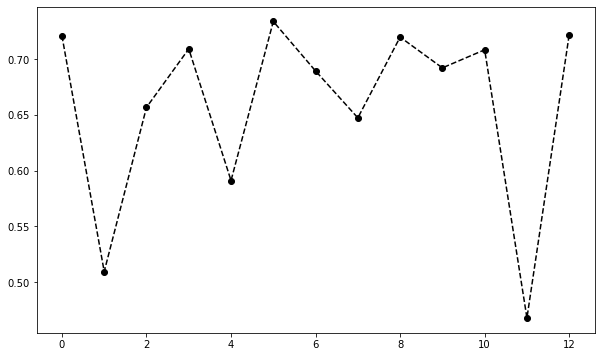

In [57]:
fig=plt.figure(figsize=(10,6))
plt.plot(n_batch,accuracy_score,'ko--')

# nonsense below

In [ ]:
sgd_clf.partial_fit(X_train_b1, Y_train_b1, classes=[True,False])

In [ ]:
accuracy=sgd_clf.score(X_train_b1,Y_train_b1)
print("Accuracy of batch 1: ",accuracy)

In [ ]:
X_train_b2 = imcl[batch_size:2*batch_size].concatenate().reshape( (5000, -1))
Y_train_b2 = Y_train_bin1[batch_size:2*batch_size]

In [ ]:
sgd_clf.partial_fit(X_train_b2, Y_train_b2)

In [ ]:
accuracy2=sgd_clf.score(X_train_b2,Y_train_b2)
print("Accuracy including batch 2: ",accuracy2)

In [ ]:
X_train_

In [ ]:
knn_clf.fit(X_train_prep,Y_train_prep)

In [ ]:
help(knn_clf.score)
#score=knn_clf.score(X_train_prep,Y_train_prep)

In [ ]:
print(score)

In [ ]:
X_test_prep = scaler.transform(X_test)
Y_test_binary = (Y_test >= 0.5)
Y_test_prep = binarizer.transform(Y_test_binary)

In [ ]:
print(X_test_prep[0].shape)

In [ ]:
Y_test_pred = knn_clf.predict([X_test_prep[0]])

In [ ]:
print(Y_test_pred[0,:])

In [ ]:
plt.figure(figsize=(12,12))
#print(Y.index[8000])
#print(probs.columns[1:].values)
Y_test_true = Y.iloc[8000,:]
#v,w=zip((Y.iloc[8000,:]).values,(Y.iloc[8000,:]).keys())#[1:3])

im_0 = mpl.image.imread("images_training_rev1/%s.jpg"%Y.index[8000])
plt.imshow(im_0,origin='lower')
for j in np.arange(0,Y_test.shape[1]):
   # print(j)
    cj=probs.columns[j]
  #  print(cj,j)
    #print(Y[c])#columns[1:])
   # print(j,c)
    print("%s "%j,"%s"%cj, "  TRUE = %s "%Y_test[0,j],\
          "PRED = %s"%Y_test_pred[0,j])#,\
                       # Y_test_pred[1+j]))

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(Y_test_prep[0], Y_test_pred))

### QUESTION: how do you predict probability of classification?

### Evaluate classifier using the test set

In [ ]:
y_test_pred = clf.predict(X_test_scaled)
y_test_scores = clf.decision_function(X_test_scaled)
y_test_score = clf.score( X_test_scaled, y_test)

Cij_test = confusion_matrix( y_test, y_test_pred)
cv_test_scores = cross_val_score(clf, X_test_scaled, y_test, cv=3, scoring='accuracy')

print(Cij_test)
print(cv_test_scores)
print(" ".join(Cij_test.ravel().astype('str')))

### TEST SET RESULTS: 

CONFUSION MATRIX:

In [ ]:
from IPython.display import display, Math
display(Math(r'%i %i \\ %i %i'.format(Cij_test)))#(Cij_test[0,0],Cij_test[0,1],Cij_test[1,0],Cij_test[1,1])))